# <게임 판매량 예측하기>

사용한 데이터셋 https://www.kaggle.com/datasets/gregorut/videogamesales

# 1. 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import Image

# 2. 데이터 로드

In [4]:
# 데이터 로드
url = "C:/Users/user/Downloads/vgsales.csv"
data = pd.read_csv(url)

In [5]:
data = data.drop(columns=["Unnamed: 0"], errors="ignore") #특징이 아닌 첫번째 데이터 삭제
data.head() #5번째 행까지 데이터 보기

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [6]:
print("\n데이터 요약 정보:\n")
print(data.info())  # 데이터 타입 확인


데이터 요약 정보:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None


In [7]:
print("\n기술 통계 정보:\n")
print(data.describe())  # 수치형 변수 통계


기술 통계 정보:

               Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
count  16598.000000  16327.000000  16598.000000  16598.000000  16598.000000   
mean    8300.605254   2006.406443      0.264667      0.146652      0.077782   
std     4791.853933      5.828981      0.816683      0.505351      0.309291   
min        1.000000   1980.000000      0.000000      0.000000      0.000000   
25%     4151.250000   2003.000000      0.000000      0.000000      0.000000   
50%     8300.500000   2007.000000      0.080000      0.020000      0.000000   
75%    12449.750000   2010.000000      0.240000      0.110000      0.040000   
max    16600.000000   2020.000000     41.490000     29.020000     10.220000   

        Other_Sales  Global_Sales  
count  16598.000000  16598.000000  
mean       0.048063      0.537441  
std        0.188588      1.555028  
min        0.000000      0.010000  
25%        0.000000      0.060000  
50%        0.010000      0.170000  
75%        0.040000     

# 3. 데이터 전처리

In [9]:
#결측치 확인
print(data.isnull().sum())

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


- Year는 수치형 변수이므로, 결측치를 중앙값으로 대체.

In [11]:
data['Year'] = data['Year'].fillna(data['Year'].median())

- publisher는 범주형 변수이므로, 결측치를 최빈값으로 대체.

In [13]:
data['Publisher'] = data['Publisher'].fillna(data['Publisher'].mode()[0])

- 중복된 행 확인

In [15]:
duplicates = data.duplicated()
print(f"중복된 데이터 개수: {duplicates.sum()}")

중복된 데이터 개수: 0


- 불필요한 열 제거

In [17]:
data.drop(['Name'], axis=1, inplace=True)

- 범주형 데이터 원-핫 인코딩

In [19]:
categorical_cols = ['Platform', 'Genre', 'Publisher']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [20]:
# 예: Global_Sales의 이상치 확인
q1 = data['Global_Sales'].quantile(0.25)
q3 = data['Global_Sales'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = data[(data['Global_Sales'] < lower_bound) | (data['Global_Sales'] > upper_bound)]
print(f"이상치 개수: {len(outliers)}")

이상치 개수: 1893


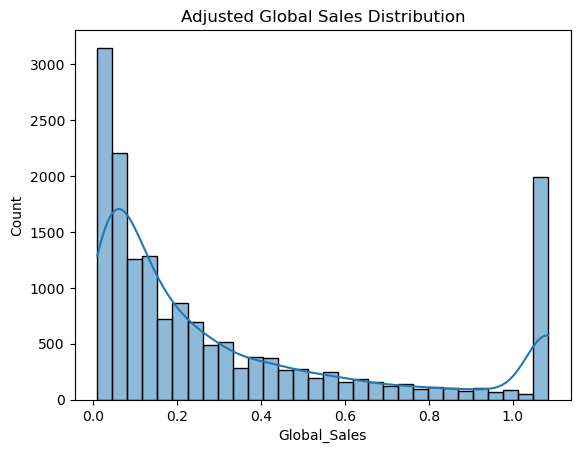

In [21]:
# 이상치 값을 경계값으로 조정 (윈저라이징)
data['Global_Sales'] = np.where(
    data['Global_Sales'] < lower_bound, lower_bound,
    np.where(data['Global_Sales'] > upper_bound, upper_bound, data['Global_Sales'])
)

# 조정 후 분포 확인
import seaborn as sns
sns.histplot(data['Global_Sales'], kde=True, bins=30)
plt.title('Adjusted Global Sales Distribution')
plt.show()

In [22]:
data.head()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform_3DO,Platform_3DS,Platform_DC,...,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
0,1,2006.0,41.49,29.02,3.77,8.46,1.085,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,1985.0,29.08,3.58,6.81,0.77,1.085,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,2008.0,15.85,12.88,3.79,3.31,1.085,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,2009.0,15.75,11.01,3.28,2.96,1.085,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,1996.0,11.27,8.89,10.22,1.00,1.085,False,False,False,...,False,False,False,False,False,False,False,False,False,False


최종 변수 - Year, NA_Sales, EU_Sales, JP_Sales, Other_Sales, 원-핫 인코딩 된 Platform, Genre, Publisher

# 4. 훈련 데이터와 테스트 데이터 분할

In [25]:
# 독립 변수 (X)와 종속 변수 (y) 분리.  여러가지 판매량 열이 존재하므로 하나를 선택해야 합니다.
X = data.drop(['Global_Sales'], axis=1)
y = data['Global_Sales'] # 예시: Global_Sales 를 예측 목표로 설정

In [26]:
# 데이터 분할 (훈련 데이터: 80%, 테스트 데이터: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print("훈련 데이터 크기:", X_train.shape)
print("테스트 데이터 크기:", X_test.shape)

훈련 데이터 크기: (13278, 624)
테스트 데이터 크기: (3320, 624)


# 5. 모델 학습

In [29]:
# 모델 초기화
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42
)

In [30]:
# 모델 학습
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [31]:
# 예측
y_pred_xgb = xgb_model.predict(X_test)

In [32]:
# 성능 평가 (MSE, R2)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [33]:
print("XGBoost Regressor MSE:", mse_xgb)
print("XGBoost Regressor R2:", r2_xgb)

XGBoost Regressor MSE: 9.415974451655514e-06
XGBoost Regressor R2: 0.9999243817196276


# 6. 학습 결과 시각화

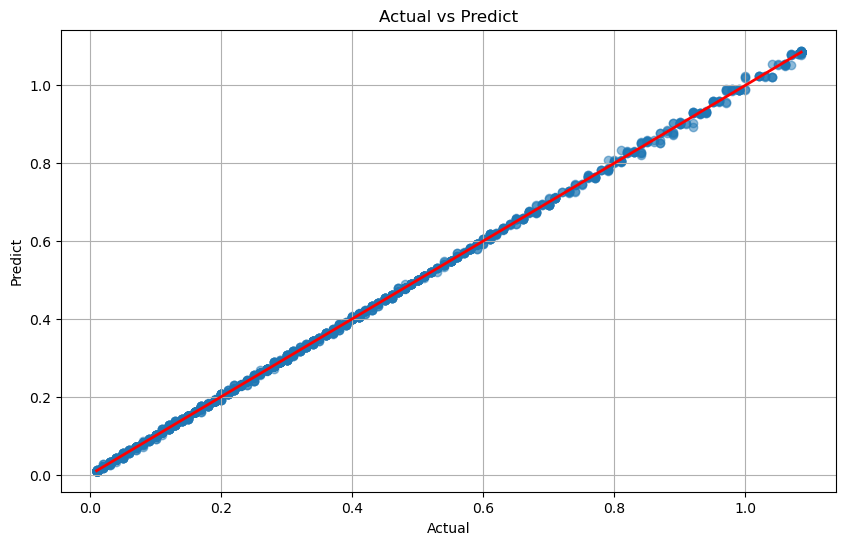

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title("Actual vs Predict")
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.grid()
plt.show()

In [36]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# 결정 트리 모델 초기화
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)

# 모델 학습
tree_model.fit(X_train, y_train)

# 예측
y_pred_tree = tree_model.predict(X_test)

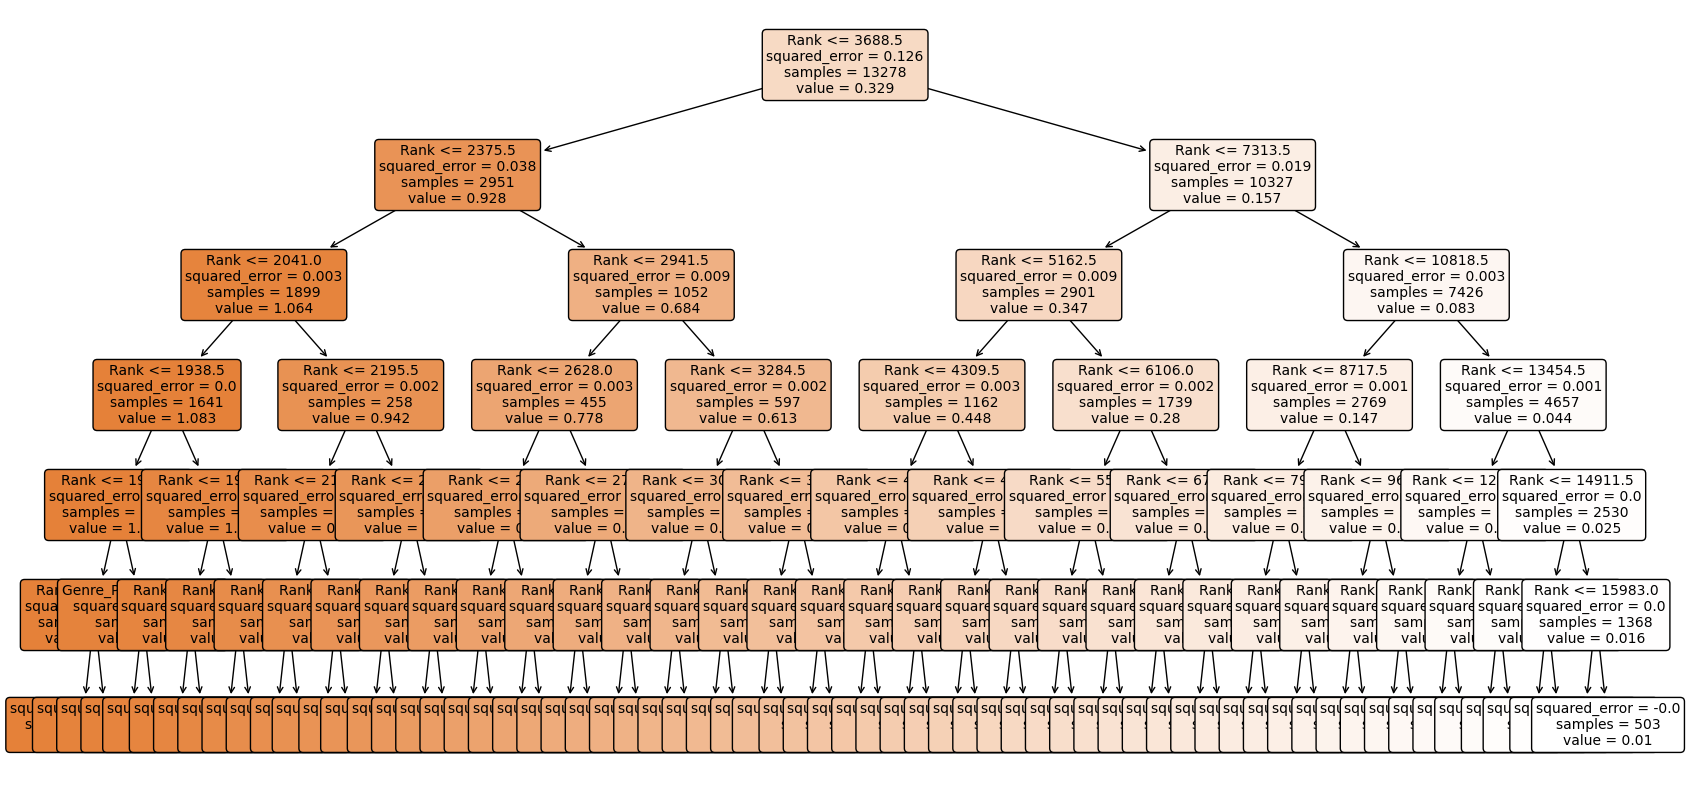

In [37]:
# 결정 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(
    tree_model, 
    feature_names=X.columns,  # 특성 이름
    filled=True,              # 색상 추가
    rounded=True,             # 박스를 둥글게
    fontsize=10               # 글꼴 크기
)
plt.show()

# chat GPT를 사용한 부분
1. 데이터 전처리 과정
- 결측치 확인 및 대체, 중복된 행 확인, 불필요한 열 제거, 범주형 데이터 원-핫 인코딩 외에 더 해야할 전처리 작업이 있을까?
 
- 이상치 처리 과정을 추천.
이상치(극단값)가 있을 경우, 모델 성능에 영향을 줄 수 있습니다. 판매량, Year, 또는 다른 수치형 데이터에서 이상치를 탐지해보세요.
이상치 값을 경계값으로 조정 (윈저라이징)
data['Global_Sales'] = np.where(
data['Global_Sales'] < lower_bound, lower_bound,
np.where(data['Global_Sales'] > upper_bound, upper_bound, data['Global_Sales'])
)

조정 후 분포 확인 import seaborn as sns
sns.histplot(data['Global_Sales'], kde=True, bins=30)
plt.title('Adjusted Global Sales Distribution')
plt.show()

2. xgb model 훈련 결과 시각화 코드
- 결정트리를 시각화하고싶은데 어떻게 하면 좋을까?
- => 주어진 코드에 맞춰 결정 트리 모델을 학습시키고 이를 시각화하는 방법을 설명드리겠습니다. XGBoost 모델을 사용하고 있지만, 결정 트리 시각화를 원하시면 sklearn.tree.DecisionTreeRegressor를 사용하여 학습 후 시각화할 수 있습니다.

1. 결정 트리 모델 학습
우선 DecisionTreeRegressor를 사용하여 결정 트리 모델을 학습합니다.

2. 결정 트리 시각화
plot_tree를 사용하여 결정 트리를 시각화할 수 있습니다. 트리의 깊이가 너무 깊어지지 않도록 max_depth를 설정해주면, 시각화가 더 명확하고 보기 쉬워집니다.

3. 결정 트리 시각화에서 중요한 부분은:

분할 조건: 각 노드에서 데이터를 어떻게 분할할지 결정하는 조건.
샘플 수: 각 노드에 포함된 샘플의 수.
타겟 값의 평균 (회귀 모델의 경우): 각 노드에서 예측된 값.
이 시각화는 모델이 데이터를 어떻게 분할하고 예측하는지 직관적으로 이해하는 데 매우 유용합니다.